In [ ]:
## Run this script to generate the surface station observations and compare it with the model simulations 

In [1]:
from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim, tk, pw, g_wind)
import wrf 
import glob
from netCDF4 import Dataset
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
import numpy as np 
import cmaps
from geopy.distance import geodesic as GD
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'IOP19')

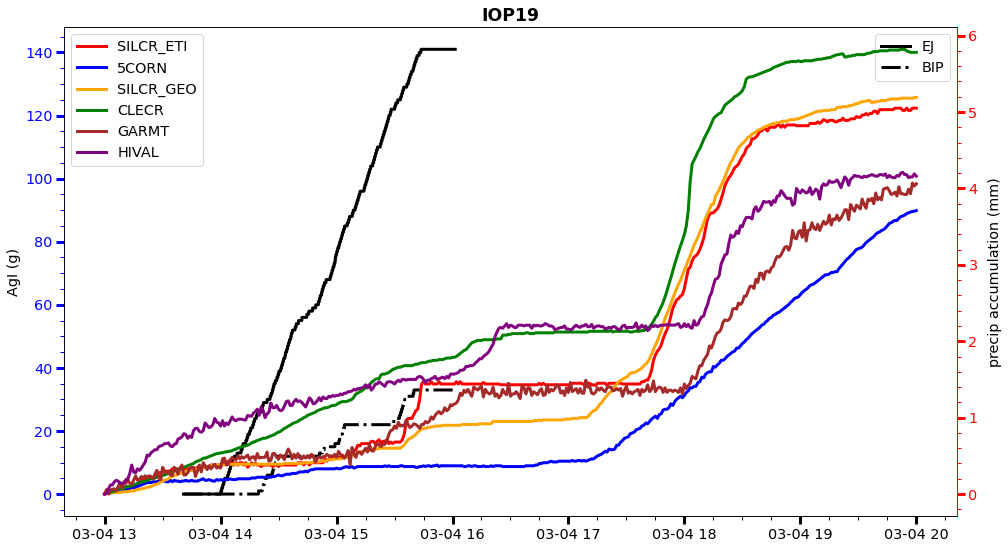

In [2]:
# #-- Extract data
#-#
## read seeding file
df = pd.read_csv("/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/Aircraft/WMI_seeding/20170304_1.csv")

seeding_time = []
for a, b in zip(df.Date, df.Time):
    test = str(a)+ ' ' + str(b)
    seeding_time.append(pd.to_datetime(test))
seeding_time = np.array(seeding_time) ## combine the date and time together

## The seeding aircraft, a Beechcraft King Air B200 operated by Weather Modification International (WMI), 
## carried up to 24 burn-in-place (BIP) flares and 306 ejectable (EJ) flares per mission

BIP = df.BIP.values ## extract the BIP (burning in place) value; BIP is through the clouds
EJ  = df.EJ.values ## extract the EJ (ejectable) value; EJ is usually released above the clouds


# #-- Visualization
#-#
fig, ax = plt.subplots(figsize=(16,9))

ax_twinx = ax.twinx()
ax.plot(seeding_time, EJ,  zorder=9, color = 'k', label='EJ', lw =3) ## plot the ejectable seeding materials
ax.plot(seeding_time, BIP, zorder=9, color = 'k', label='BIP', ls='-.', lw=3) ## plot the BIP seeding materials
ax.set_ylabel("AgI (g)", fontsize='x-large')
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue',length=8, width=3, labelsize='x-large')
ax.tick_params(axis='y', colors='blue',which='minor',length=4, width=1, labelsize='x-large')
ax.tick_params(axis='x',length=8, width=3, labelsize='x-large')
ax.tick_params(axis='x',which='minor',length=4, width=1, labelsize='x-large')
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.legend(fontsize='x-large')

## read ground gauge data
color_list = [ 'red', 'blue', 'orange', 'green', 'brown', 'purple', 'cyan'] ## color list
station_ID = ['SILCR_ETI', '5CORN', 'SILCR_GEO', 'CLECR','GARMT', 'HIVAL'] ## station name

dir_path   = "/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/IOP19_Snow_acc/" ## IOP19 snowfall data
files_list = ['IOP19_PG_ETI_SilverCreek_20170304_lv1.csv','IOP19_PG_Geonor_1min_5Corners_20170304_lv1 copy.csv',
 'IOP19_PG_Geonor_SilverCreek_20170304_lv1.csv', 'IOP19_PG_Geonor_ClearCreek_20170304_lv1.csv',
 'IOP19_PG_Geonor_1min_GardenMtn_20170304_lv1.csv', 'IOP19_PG_Geonor_1min_HighValley_20170304_lv1.csv']

##-----------------------
start_time = pd.to_datetime('20170304 1300') ## beginning time
end_time   = pd.to_datetime('20170304 2000') ## ending time; this period cover but not limited for the IOP19 period
for file, i, c in zip(files_list, range(6), color_list):
    f    = dir_path + file
    df   = pd.read_csv(f)
    snow = df['snow'].values
    time = pd.to_datetime(df.iloc[:, 0].values)
    sel_ind = np.where((time >= start_time) & (time <= end_time))[0]
    sel_time = time[sel_ind]
    sel_snow = snow[sel_ind]
    ax_twinx.plot(sel_time, sel_snow-sel_snow[0], label = station_ID[i], lw = 3, color=c)
    

ax_twinx.set_ylabel("precip accumulation (mm)", fontsize='x-large', labelpad = 10)
ax_twinx.spines['right'].set_color('red')
ax_twinx.legend(fontsize='x-large')
ax_twinx.tick_params(axis='y', colors='red', length=8, width=3, labelsize='x-large')
ax_twinx.tick_params(axis='y',colors='red',which='minor',length=4, width=1, labelsize='x-large')
ax_twinx.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_twinx.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_twinx.set_title("IOP19",  fontsize='xx-large', fontweight='bold')

In [3]:
## now let's extract the simulated data for ground precipitation

In [4]:
def get_lat_lon(file_path):
    wrf_file1 = file_path
    wrf_data1 = Dataset(wrf_file1)
    Height_wrf   = getvar(wrf_data1, "z")
    wrf_lat   = getvar(wrf_data1, "XLAT")
    wrf_lon   = getvar(wrf_data1, "XLONG")
    
    return wrf_lat, wrf_lon, Height_wrf

def nearest_position( stn_lat, stn_lon, xlat, xlon ):
    """
    Area of Interest
    Crouch: 1082.6 m MSL, 44°08'58.1", −115°59'25.4" ==> 44.143 degree, -115.988 degree
    Lowman: 1315.0 m MSL, 44°06'01.2", −115°27'34.0"
    get the nearest grid location index
    parameters:
    ----------------------
    lon  : for single station; lat  : for single station
    lons : numpy.ndarray; 2d coordinate; lats : numpy.ndarray; 2d coordinate
    Return:
    -----------------------
    (xindx,yindx)

    """
    difflat = stn_lat - xlat; difflon = stn_lon - xlon;
    rad = np.multiply(difflat, difflat) + np.multiply(difflon, difflon) # difflat * difflat + difflon * difflon
    aa  = np.where(rad == np.min(rad)); ind = np.squeeze(np.array(aa))
    lat_ind = ind[0]; lon_ind = ind[1]
    # print("lat:", lat_ind, "\tlon:", lon_ind)
    
    return lat_ind, lon_ind

file_path_900m = "/glade/scratch/zhixing/900m_Four_Driving_Datasets/WRF_IOP19_ERA5/wrfout_d01_2017-03-04_14:00:00"  ## the ERA5 simulation data (900m)

## extract the index for 900m domain
wrf_lat_900m, wrf_lon_900m, Height_wrf_900m = get_lat_lon(file_path = file_path_900m) ## extract the 2d lat/lon coordinate
lat_ind_cc_900m, lon_ind_cc_900m = nearest_position(stn_lat = 44.4832, stn_lon = -115.8483, xlat=wrf_lat_900m, xlon=wrf_lon_900m)   ## the Clear Creek
lat_ind_gmt_900m, lon_ind_gmt_900m = nearest_position(stn_lat = 44.1344, stn_lon = -116.0559, xlat=wrf_lat_900m, xlon=wrf_lon_900m) ## the Garden Mountain
lat_ind_sc_900m, lon_ind_sc_900m = nearest_position(stn_lat = 44.3358, stn_lon = -115.7988, xlat=wrf_lat_900m, xlon=wrf_lon_900m)   ## the Silver Creek
lat_ind_fc_900m, lon_ind_fc_900m = nearest_position(stn_lat = 43.996, stn_lon = -115.6582, xlat=wrf_lat_900m, xlon=wrf_lon_900m)    ## the Five Corner
lat_ind_hv_900m, lon_ind_hv_900m = nearest_position(stn_lat = 44.2662, stn_lon = -116.1168, xlat=wrf_lat_900m, xlon=wrf_lon_900m)   ## the HighValley

In [5]:
%%time
# #-- extract variables from the WRF output data
#-#

##------ 900m ERA5
file_dir = '/glade/scratch/zhixing/900m_Four_Driving_Datasets/WRF_IOP19_ERA5/' ## 1200-1800 UTC for this simulation period; But the observation period is 1300-2000 UTC
wrffile_list = glob.glob(file_dir+"wrfout*") ## read all the files under this directory
wrffile_list.sort()
wrffiles = []
for f in wrffile_list[12:]:
    wrffile = Dataset(f)
    wrffiles.append(wrffile)
rainnc_ERA5_900m  = getvar(wrffiles, 'RAINNC', timeidx=ALL_TIMES, method = "cat")  ## accumulated total grid scale precipitation amounts (mm); (Time:61 south_north:600 west_east: 900)


##------ 900m ERAI
file_dir = '/glade/scratch/zhixing/900m_Four_Driving_Datasets/WRF_IOP19_ERAI/' ## 1200-1800 UTC for this simulation period; But the observation period is 1300-2000 UTC
wrffile_list = glob.glob(file_dir+"wrfout*") ## read all the files under this directory
wrffile_list.sort()
wrffiles = []
for f in wrffile_list[12:]:
    wrffile = Dataset(f)
    wrffiles.append(wrffile)
rainnc_ERAI_900m  = getvar(wrffiles, 'RAINNC', timeidx=ALL_TIMES, method = "cat")  ## accumulated total grid scale precipitation amounts (mm); (Time:61 south_north:600 west_east: 900)


##------ 900m NARR
file_dir = '/glade/scratch/zhixing/900m_Four_Driving_Datasets/WRF_IOP19_NARR/' ## 1200-1800 UTC for this simulation period; But the observation period is 1300-2000 UTC
wrffile_list = glob.glob(file_dir+"wrfout*") ## read all the files under this directory
wrffile_list.sort()
wrffiles = []
for f in wrffile_list[12:]:
    wrffile = Dataset(f)
    wrffiles.append(wrffile)
rainnc_NARR_900m  = getvar(wrffiles, 'RAINNC', timeidx=ALL_TIMES, method = "cat")  ## accumulated total grid scale precipitation amounts (mm); (Time:61 south_north:600 west_east: 900)


##------ 900m CFS2
file_dir = '/glade/scratch/zhixing/900m_Four_Driving_Datasets/WRF_IOP19_CFS2/' ## 1200-1800 UTC for this simulation period; But the observation period is 1300-2000 UTC
wrffile_list = glob.glob(file_dir+"wrfout*") ## read all the files under this directory
wrffile_list.sort()
wrffiles = []
for f in wrffile_list[12:]:
    wrffile = Dataset(f)
    wrffiles.append(wrffile)
rainnc_CFS2_900m  = getvar(wrffiles, 'RAINNC', timeidx=ALL_TIMES, method = "cat")  ## accumulated total grid scale precipitation amounts (mm)

CPU times: user 32.5 s, sys: 3.96 s, total: 36.4 s
Wall time: 1min 19s


In [6]:
rainnc_X_900m_dic = {'ERA5': rainnc_ERA5_900m, 'ERAI':rainnc_ERAI_900m, 'NARR':rainnc_NARR_900m, 'CFS2':rainnc_CFS2_900m}

keys_list = ['ERA5', 'ERAI', 'NARR', 'CFS2'] ## the reanalysis dataset

avg_rainnc_X_900m_dic = {}; std_rainnc_X_900m_dic = {}

for keys in keys_list:
    
    rainnc_X_900m = rainnc_X_900m_dic[keys]

    cc_rain_X_900m_list = []; gmt_rain_X_900m_list = []; sc_rain_X_900m_list = []; fc_rain_X_900m_list = []; hv_rain_X_900m_list = []; 
    for i in range(-2,3):
        for j in range(-2,3):
            ## choose the 5*5 size gridded area
            cc_rain_X_900m  = rainnc_X_900m.values[:,lat_ind_cc_900m+i,lon_ind_cc_900m+j]; cc_rain_X_900m_list.append(cc_rain_X_900m)
            gmt_rain_X_900m = rainnc_X_900m.values[:,lat_ind_gmt_900m+i,lon_ind_gmt_900m+j]; gmt_rain_X_900m_list.append(gmt_rain_X_900m)
            sc_rain_X_900m  = rainnc_X_900m.values[:,lat_ind_sc_900m+i,lon_ind_sc_900m+j]; sc_rain_X_900m_list.append(sc_rain_X_900m)
            fc_rain_X_900m  = rainnc_X_900m.values[:,lat_ind_fc_900m+i,lon_ind_fc_900m+j]; fc_rain_X_900m_list.append(fc_rain_X_900m)
            hv_rain_X_900m  = rainnc_X_900m.values[:,lat_ind_hv_900m+i,lon_ind_hv_900m+j]; hv_rain_X_900m_list.append(hv_rain_X_900m)

    cc_rain_X_900m_list = np.array(cc_rain_X_900m_list);  gmt_rain_X_900m_list = np.array(gmt_rain_X_900m_list)
    sc_rain_X_900m_list = np.array(sc_rain_X_900m_list);  fc_rain_X_900m_list  = np.array(fc_rain_X_900m_list); hv_rain_X_900m_list = np.array(hv_rain_X_900m_list)

    ## the averaged value (via neighborhood approach) of ground precip accumulation value 
    avg_cc_rain_X_900m_list = np.mean(cc_rain_X_900m_list,axis=0);  avg_gmt_rain_X_900m_list = np.mean(gmt_rain_X_900m_list,axis=0)
    avg_sc_rain_X_900m_list = np.mean(sc_rain_X_900m_list,axis=0);  avg_fc_rain_X_900m_list  = np.mean(fc_rain_X_900m_list,axis=0);  
    avg_hv_rain_X_900m_list = np.mean(hv_rain_X_900m_list,axis=0)
    
    ## the standard deviation of ground precip accumulation value
    std_cc_rain_X_900m_list = np.std(cc_rain_X_900m_list,axis=0);  std_gmt_rain_X_900m_list = np.std(gmt_rain_X_900m_list,axis=0)
    std_sc_rain_X_900m_list = np.std(sc_rain_X_900m_list,axis=0);  std_fc_rain_X_900m_list  = np.std(fc_rain_X_900m_list,axis=0);  
    std_hv_rain_X_900m_list = np.std(hv_rain_X_900m_list,axis=0)
    
    avg_rainnc_X_900m_dic[keys] = {'cc':avg_cc_rain_X_900m_list,'gmt':avg_gmt_rain_X_900m_list,'sc':avg_sc_rain_X_900m_list,'fc':avg_fc_rain_X_900m_list,'hv':avg_hv_rain_X_900m_list}
    std_rainnc_X_900m_dic[keys] = {'cc':std_cc_rain_X_900m_list,'gmt':std_gmt_rain_X_900m_list,'sc':std_sc_rain_X_900m_list,'fc':std_fc_rain_X_900m_list,'hv':std_hv_rain_X_900m_list}
    
## now we get the dictionary data of averaged rainnc for different driving datasets at different gauge sites
## now we get the dictionary data of standardized rainnc for different driving datasets at different gauge sites

Text(0.5, 0, 'Time (UTC)')

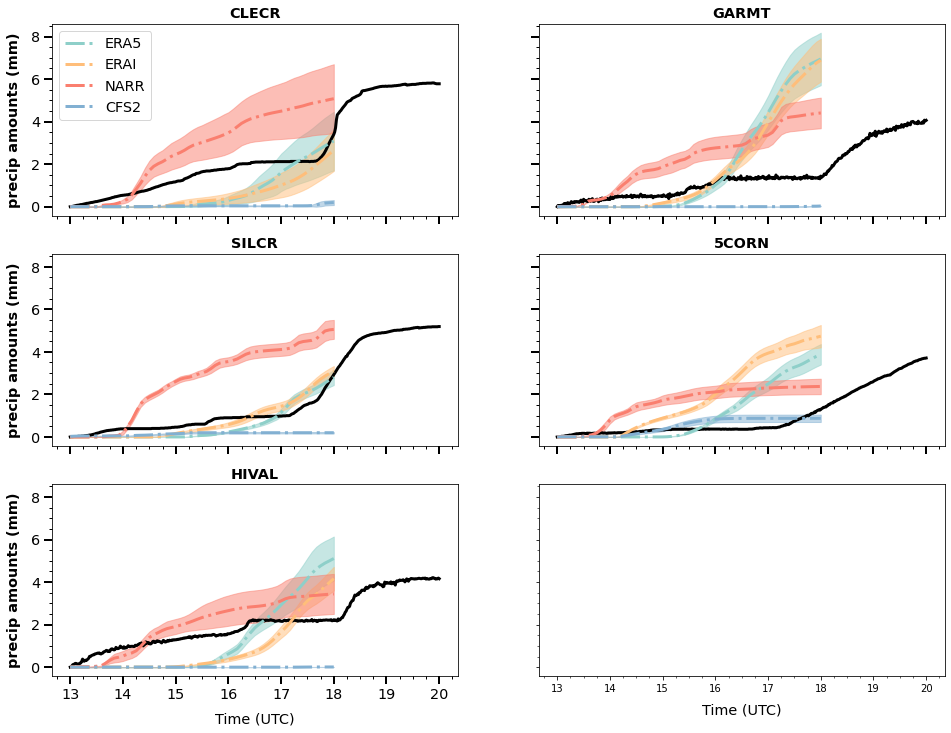

In [36]:
# #-- Visualize the evolution of ground precipitation from observations and WRF simulations
#-#

reanalysis_list = ['ERA5','ERAI', 'NARR', 'CFS2'] ## the reanalysis dataset we used
station_list    = ['cc', 'gmt', 'sc', 'fc', 'hv'] ## the station site
station_ID      = ['CLECR','GARMT','SILCR','5CORN','HIVAL'] 
color_list      = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2'] ## the color we want to use
model_time      = pd.date_range('20170304 1300', '20170304 1800', freq = '5min')

fig, axs = plt.subplots(3,2,figsize=(16,12), sharex=True, sharey=True)

dir_path   = "/glade/work/zhixing/Analysis_DATA/SNOWIE_observation/IOP19_Snow_acc/" ## IOP19 snowfall data
files_list = ['IOP19_PG_Geonor_ClearCreek_20170304_lv1.csv','IOP19_PG_Geonor_1min_GardenMtn_20170304_lv1.csv','IOP19_PG_Geonor_SilverCreek_20170304_lv1.csv',\
             'IOP19_PG_Geonor_1min_5Corners_20170304_lv1 copy.csv','IOP19_PG_Geonor_1min_HighValley_20170304_lv1.csv']

start_time = pd.to_datetime('20170304 1300') ## beginning time
end_time   = pd.to_datetime('20170304 2000') ## ending time; this period cover but not limited for the IOP19 period


for site, site_ID, ax, file in zip(station_list, station_ID, np.array(axs).flatten(), files_list):
            
    f    = dir_path + file
    df   = pd.read_csv(f)
    snow = df['snow'].values
    time = pd.to_datetime(df.iloc[:, 0].values)
    sel_ind = np.where((time >= start_time) & (time <= end_time))[0]
    sel_time = time[sel_ind]
    sel_snow = snow[sel_ind]
    ax.plot(sel_time, sel_snow-sel_snow[0], lw = 3, color='k')
    ax.set_title(site_ID, fontsize='x-large', fontweight='bold')
    
    for keys, color in zip(reanalysis_list, color_list):
        
        mean_val_rain = avg_rainnc_X_900m_dic[keys][site]
        std_val_rain  = std_rainnc_X_900m_dic[keys][site]
        
        ax.plot(model_time, mean_val_rain, color = color, label = keys, lw = 3, ls = '-.')
        ax.fill_between(model_time, mean_val_rain - std_val_rain, mean_val_rain + std_val_rain, color = color, alpha = 0.5)

    ax.tick_params(axis='both',length=8,width=2,labelsize='x-large')
    ax.tick_params(which='minor',labelsize='x-large',  length=3, width=1, pad=1)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    
    ax.set_xticklabels(['13','14','15','16','17','18','19','20'])
    
axs[0,0].legend(fontsize='x-large')
axs[0,0].set_ylabel("precip amounts (mm)", fontsize='x-large', fontweight='bold', labelpad = 10) 
axs[1,0].set_ylabel("precip amounts (mm)", fontsize='x-large', fontweight='bold', labelpad = 10) 
axs[2,0].set_ylabel("precip amounts (mm)", fontsize='x-large', fontweight='bold', labelpad = 10) 
axs[-1,0].set_xlabel('Time (UTC)', fontsize='x-large', labelpad = 10)
axs[-1,1].set_xlabel('Time (UTC)', fontsize='x-large', labelpad = 10)